# 🚨 DomusAI - Detección de Anomalías en Consumo Energético

**Objetivo**: Identificar patrones de consumo anómalos utilizando múltiples métodos de detección.

**Dataset**: `Dataset_clean_test.csv` (260,640 registros, 1-min resolution)

**Fecha**: Octubre 2025

---

## 📋 Contenido del Notebook

1. **Setup y Carga de Datos**
2. **Exploración Inicial de Outliers**
3. **Método 1: IQR (Inter-Quartile Range)**
4. **Método 2: Z-Score (Statistical)**
5. **Método 3: Isolation Forest (Machine Learning)**
6. **Método 4: Moving Average + Threshold**
7. **Método 5: Prediction-Based (usando Predictor)**
8. **Comparación de Métodos**
9. **Clasificación de Tipos de Anomalías**
10. **Conclusiones y Próximos Pasos**

---

## 1️⃣ Setup y Carga de Datos

Importamos librerías necesarias y cargamos el dataset limpio.

In [1]:
# Imports básicos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Librerías para detección de anomalías
from scipy import stats
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Configuración de Pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.3f}'.format)

print("✅ Librerías importadas correctamente")
print(f"📦 Pandas: {pd.__version__}")
print(f"📦 NumPy: {np.__version__}")

✅ Librerías importadas correctamente
📦 Pandas: 2.3.2
📦 NumPy: 1.26.4


In [2]:
# Cargar dataset limpio
print("🔄 Cargando dataset limpio...")

df = pd.read_csv(
    '../data/Dataset_clean_test.csv',
    parse_dates=['Datetime'],
    index_col='Datetime'
)

print(f"✅ Dataset cargado: {len(df):,} registros")
print(f"📅 Período: {df.index.min()} a {df.index.max()}")
print(f"📊 Columnas: {list(df.columns)}")
print(f"\n{df.head()}")

🔄 Cargando dataset limpio...
✅ Dataset cargado: 260,640 registros
📅 Período: 2007-01-01 00:00:00 a 2007-06-30 23:59:00
📊 Columnas: ['Global_active_power', 'Global_reactive_power', 'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

                     Global_active_power  Global_reactive_power  Voltage  \
Datetime                                                                   
2007-01-01 00:00:00                2.580                  0.136  241.970   
2007-01-01 00:01:00                2.552                  0.100  241.750   
2007-01-01 00:02:00                2.550                  0.100  241.640   
2007-01-01 00:03:00                2.550                  0.100  241.710   
2007-01-01 00:04:00                2.554                  0.100  241.980   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2007-01-01 00:00:00            10.600           0.000  

In [3]:
# Información del dataset
print("📊 Información del Dataset")
print("=" * 60)
df.info()
print("\n📈 Estadísticas Descriptivas")
print("=" * 60)
print(df.describe())

📊 Información del Dataset
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 260640 entries, 2007-01-01 00:00:00 to 2007-06-30 23:59:00
Data columns (total 7 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Global_active_power    256869 non-null  float64
 1   Global_reactive_power  256869 non-null  float64
 2   Voltage                256869 non-null  float64
 3   Global_intensity       256869 non-null  float64
 4   Sub_metering_1         256869 non-null  float64
 5   Sub_metering_2         256869 non-null  float64
 6   Sub_metering_3         260640 non-null  float64
dtypes: float64(7)
memory usage: 15.9 MB

📈 Estadísticas Descriptivas
       Global_active_power  Global_reactive_power    Voltage  \
count           256869.000             256869.000 256869.000   
mean                 1.165                  0.124    239.209   
std                  1.182                  0.112      3.593   
min                  0.082 

## 2️⃣ Exploración Inicial de Outliers

Visualizamos la distribución de la variable principal (`Global_active_power`) para identificar valores extremos.

In [4]:
# Función auxiliar para visualización de anomalías
def plot_consumption_with_anomalies(df, anomalies_idx, title="Consumo con Anomalías Detectadas", sample_days=7):
    """
    Visualiza consumo energético con anomalías marcadas en rojo.
    
    Args:
        df: DataFrame con datos de consumo
        anomalies_idx: Índices de las anomalías detectadas
        title: Título del gráfico
        sample_days: Número de días a mostrar (para evitar sobrecarga)
    """
    # Tomar muestra de datos (últimos N días)
    end_date = df.index.max()
    start_date = end_date - pd.Timedelta(days=sample_days)
    df_sample = df.loc[start_date:end_date]
    
    # Filtrar anomalías en el rango
    anomalies_sample = df.loc[anomalies_idx]
    anomalies_sample = anomalies_sample.loc[start_date:end_date]
    
    # Crear gráfico interactivo
    fig = go.Figure()
    
    # Línea de consumo normal
    fig.add_trace(go.Scatter(
        x=df_sample.index,
        y=df_sample['Global_active_power'],
        mode='lines',
        name='Consumo Normal',
        line=dict(color='blue', width=1),
        opacity=0.7
    ))
    
    # Puntos de anomalías
    if len(anomalies_sample) > 0:
        fig.add_trace(go.Scatter(
            x=anomalies_sample.index,
            y=anomalies_sample['Global_active_power'],
            mode='markers',
            name='Anomalías',
            marker=dict(color='red', size=8, symbol='x'),
            opacity=1.0
        ))
    
    fig.update_layout(
        title=f"{title} (Últimos {sample_days} días)",
        xaxis_title="Fecha",
        yaxis_title="Potencia Activa (kW)",
        hovermode='x unified',
        template='plotly_white',
        height=500
    )
    
    fig.show()
    
    # Estadísticas de anomalías
    total_points = len(df_sample)
    anomaly_count = len(anomalies_sample)
    anomaly_rate = (anomaly_count / total_points * 100) if total_points > 0 else 0
    
    print(f"\n📊 Estadísticas de Anomalías (últimos {sample_days} días)")
    print(f"Total de puntos: {total_points:,}")
    print(f"Anomalías detectadas: {anomaly_count:,} ({anomaly_rate:.2f}%)")
    if anomaly_count > 0:
        print(f"Consumo promedio normal: {df_sample['Global_active_power'].mean():.3f} kW")
        print(f"Consumo promedio anomalías: {anomalies_sample['Global_active_power'].mean():.3f} kW")

print("✅ Función de visualización definida")

✅ Función de visualización definida


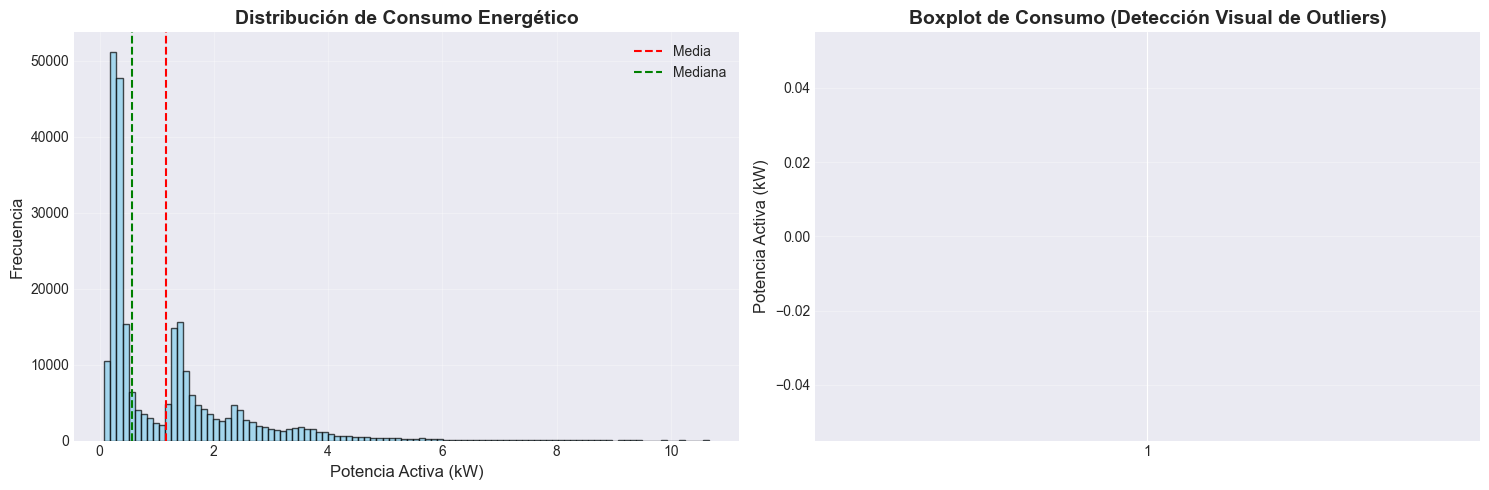


📊 Estadísticas Básicas de Global_active_power
Media: 1.165 kW
Mediana: 0.564 kW
Desviación Estándar: 1.182 kW
Mínimo: 0.082 kW
Máximo: 10.670 kW
Rango: 10.588 kW


In [5]:
# Visualización de distribución
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(df['Global_active_power'], bins=100, color='skyblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Potencia Activa (kW)', fontsize=12)
axes[0].set_ylabel('Frecuencia', fontsize=12)
axes[0].set_title('Distribución de Consumo Energético', fontsize=14, fontweight='bold')
axes[0].axvline(df['Global_active_power'].mean(), color='red', linestyle='--', label='Media')
axes[0].axvline(df['Global_active_power'].median(), color='green', linestyle='--', label='Mediana')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Boxplot
axes[1].boxplot(df['Global_active_power'], vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7),
                medianprops=dict(color='red', linewidth=2),
                whiskerprops=dict(color='blue', linewidth=1.5),
                capprops=dict(color='blue', linewidth=1.5))
axes[1].set_ylabel('Potencia Activa (kW)', fontsize=12)
axes[1].set_title('Boxplot de Consumo (Detección Visual de Outliers)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n📊 Estadísticas Básicas de Global_active_power")
print("=" * 60)
print(f"Media: {df['Global_active_power'].mean():.3f} kW")
print(f"Mediana: {df['Global_active_power'].median():.3f} kW")
print(f"Desviación Estándar: {df['Global_active_power'].std():.3f} kW")
print(f"Mínimo: {df['Global_active_power'].min():.3f} kW")
print(f"Máximo: {df['Global_active_power'].max():.3f} kW")
print(f"Rango: {df['Global_active_power'].max() - df['Global_active_power'].min():.3f} kW")

## 3️⃣ Método 1: IQR (Inter-Quartile Range)

**Concepto**: Detecta outliers usando el rango intercuartílico.

**Fórmula**:
- $Q1 = \text{Percentil 25}$
- $Q3 = \text{Percentil 75}$
- $IQR = Q3 - Q1$
- **Outliers**: Valores fuera de $[Q1 - 1.5 \times IQR, Q3 + 1.5 \times IQR]$

**Ventajas**: Simple, robusto, interpretable  
**Desventajas**: No considera dependencias temporales

In [6]:
# Función para detección IQR
def detect_anomalies_iqr(df, column='Global_active_power', multiplier=1.5):
    """
    Detecta anomalías usando el método IQR (Inter-Quartile Range).
    
    Args:
        df: DataFrame con datos
        column: Columna a analizar
        multiplier: Multiplicador del IQR (default: 1.5 para outliers moderados)
    
    Returns:
        tuple: (anomalies_df, stats_dict)
    """
    # Calcular cuartiles
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    
    # Calcular límites
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    
    # Detectar anomalías
    anomalies = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    
    # Estadísticas
    stats = {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_bound': lower_bound,
        'upper_bound': upper_bound,
        'total_anomalies': len(anomalies),
        'anomaly_rate': len(anomalies) / len(df) * 100,
        'below_lower': len(df[df[column] < lower_bound]),
        'above_upper': len(df[df[column] > upper_bound])
    }
    
    return anomalies, stats

print("✅ Función detect_anomalies_iqr definida")

✅ Función detect_anomalies_iqr definida


In [7]:
# Aplicar detección IQR
print("🔍 Detectando anomalías con método IQR...\n")

anomalies_iqr, stats_iqr = detect_anomalies_iqr(df, column='Global_active_power', multiplier=1.5)

print("📊 Resultados de Detección IQR")
print("=" * 60)
print(f"Q1 (25%): {stats_iqr['Q1']:.3f} kW")
print(f"Q3 (75%): {stats_iqr['Q3']:.3f} kW")
print(f"IQR: {stats_iqr['IQR']:.3f} kW")
print(f"\nLímite inferior: {stats_iqr['lower_bound']:.3f} kW")
print(f"Límite superior: {stats_iqr['upper_bound']:.3f} kW")
print(f"\n🚨 Total de anomalías detectadas: {stats_iqr['total_anomalies']:,} ({stats_iqr['anomaly_rate']:.2f}%)")
print(f"   - Por debajo del límite inferior: {stats_iqr['below_lower']:,}")
print(f"   - Por encima del límite superior: {stats_iqr['above_upper']:,}")

# Mostrar ejemplos de anomalías
print(f"\n📋 Primeras 10 anomalías detectadas:")
print(anomalies_iqr[['Global_active_power', 'Voltage', 'Global_intensity']].head(10))

🔍 Detectando anomalías con método IQR...

📊 Resultados de Detección IQR
Q1 (25%): 0.296 kW
Q3 (75%): 1.606 kW
IQR: 1.310 kW

Límite inferior: -1.669 kW
Límite superior: 3.571 kW

🚨 Total de anomalías detectadas: 13,664 (5.24%)
   - Por debajo del límite inferior: 0
   - Por encima del límite superior: 13,664

📋 Primeras 10 anomalías detectadas:
                     Global_active_power  Voltage  Global_intensity
Datetime                                                           
2007-01-02 20:10:00                3.688  235.800            16.400
2007-01-03 21:19:00                3.618  239.940            15.000
2007-01-03 21:20:00                3.596  240.200            15.000
2007-01-03 23:19:00                5.068  243.490            20.800
2007-01-03 23:20:00                5.182  243.500            21.200
2007-01-03 23:21:00                5.190  243.710            21.200
2007-01-04 00:16:00                4.010  240.430            16.600
2007-01-04 00:17:00                3.786 

In [8]:
# Visualizar anomalías IQR
plot_consumption_with_anomalies(
    df, 
    anomalies_iqr.index, 
    title="Método IQR - Anomalías Detectadas",
    sample_days=14
)


📊 Estadísticas de Anomalías (últimos 14 días)
Total de puntos: 20,161
Anomalías detectadas: 494 (2.45%)
Consumo promedio normal: 0.721 kW
Consumo promedio anomalías: 4.493 kW


## 4️⃣ Método 2: Z-Score (Statistical)

**Concepto**: Detecta valores que están a más de N desviaciones estándar de la media.

**Fórmula**:
$$Z = \frac{X - \mu}{\sigma}$$

Donde:
- $X$ = Valor observado
- $\mu$ = Media
- $\sigma$ = Desviación estándar

**Threshold típico**: $|Z| > 3$ (99.7% de datos normales están dentro de ±3σ)

**Ventajas**: Basado en distribución normal, interpretable  
**Desventajas**: Asume normalidad de datos

In [9]:
# Función para detección Z-Score
def detect_anomalies_zscore(df, column='Global_active_power', threshold=3.0):
    """
    Detecta anomalías usando Z-Score (desviaciones estándar).
    
    Args:
        df: DataFrame con datos
        column: Columna a analizar
        threshold: Número de desviaciones estándar (default: 3.0)
    
    Returns:
        tuple: (anomalies_df, stats_dict)
    """
    # Calcular media y desviación estándar
    mean = df[column].mean()
    std = df[column].std()
    
    # Calcular Z-Score
    z_scores = np.abs((df[column] - mean) / std)
    
    # Detectar anomalías (|Z| > threshold)
    anomalies = df[z_scores > threshold].copy()
    anomalies['z_score'] = z_scores[z_scores > threshold]
    
    # Estadísticas
    stats = {
        'mean': mean,
        'std': std,
        'threshold': threshold,
        'total_anomalies': len(anomalies),
        'anomaly_rate': len(anomalies) / len(df) * 100,
        'max_z_score': z_scores.max(),
        'min_z_score': z_scores.min()
    }
    
    return anomalies, stats

print("✅ Función detect_anomalies_zscore definida")

✅ Función detect_anomalies_zscore definida


In [10]:
# Aplicar detección Z-Score
print("🔍 Detectando anomalías con método Z-Score...\n")

anomalies_zscore, stats_zscore = detect_anomalies_zscore(df, column='Global_active_power', threshold=3.0)

print("📊 Resultados de Detección Z-Score")
print("=" * 60)
print(f"Media (μ): {stats_zscore['mean']:.3f} kW")
print(f"Desviación Estándar (σ): {stats_zscore['std']:.3f} kW")
print(f"Threshold: |Z| > {stats_zscore['threshold']}")
print(f"\n🚨 Total de anomalías detectadas: {stats_zscore['total_anomalies']:,} ({stats_zscore['anomaly_rate']:.2f}%)")
print(f"Z-Score máximo: {stats_zscore['max_z_score']:.2f}σ")

# Mostrar ejemplos con Z-Score
print(f"\n📋 Top 10 anomalías por Z-Score:")
print(anomalies_zscore[['Global_active_power', 'z_score']].sort_values('z_score', ascending=False).head(10))

🔍 Detectando anomalías con método Z-Score...

📊 Resultados de Detección Z-Score
Media (μ): 1.165 kW
Desviación Estándar (σ): 1.182 kW
Threshold: |Z| > 3.0

🚨 Total de anomalías detectadas: 4,470 (1.72%)
Z-Score máximo: 8.04σ

📋 Top 10 anomalías por Z-Score:
                     Global_active_power  z_score
Datetime                                         
2007-03-04 19:34:00               10.670    8.043
2007-03-04 19:33:00               10.650    8.026
2007-03-04 19:32:00               10.154    7.606
2007-03-04 19:35:00                9.922    7.410
2007-03-05 07:13:00                9.486    7.041
2007-02-22 21:15:00                9.410    6.977
2007-02-22 21:09:00                9.392    6.961
2007-02-22 21:08:00                9.374    6.946
2007-02-22 21:14:00                9.338    6.916
2007-02-22 21:07:00                9.316    6.897


In [11]:
# Visualizar anomalías Z-Score
plot_consumption_with_anomalies(
    df, 
    anomalies_zscore.index, 
    title="Método Z-Score - Anomalías Detectadas (|Z| > 3σ)",
    sample_days=14
)


📊 Estadísticas de Anomalías (últimos 14 días)
Total de puntos: 20,161
Anomalías detectadas: 151 (0.75%)
Consumo promedio normal: 0.721 kW
Consumo promedio anomalías: 5.631 kW


## 5️⃣ Método 3: Isolation Forest (Machine Learning)

**Concepto**: Algoritmo de ML basado en árboles que aísla anomalías.

**Cómo funciona**:
1. Construye árboles de decisión aleatorios
2. Las anomalías se aíslan en menos particiones (cerca de la raíz)
3. Los puntos normales requieren más particiones (lejos de la raíz)

**Parámetro clave**: `contamination` = % esperado de anomalías (default: 0.05 = 5%)

**Ventajas**: No asume distribución, multivariate  
**Desventajas**: Requiere ajuste de contamination

In [12]:
# Función para detección Isolation Forest
def detect_anomalies_isolation_forest(df, columns=['Global_active_power'], contamination=0.05, random_state=42):
    """
    Detecta anomalías usando Isolation Forest (sklearn).
    
    Args:
        df: DataFrame con datos
        columns: Lista de columnas a usar como features
        contamination: Proporción esperada de anomalías (0.01 - 0.10)
        random_state: Seed para reproducibilidad
    
    Returns:
        tuple: (anomalies_df, stats_dict, model)
    """
    # Preparar datos
    X = df[columns].values
    
    # Entrenar modelo
    iso_forest = IsolationForest(
        contamination=contamination,
        random_state=random_state,
        n_estimators=100
    )
    
    print(f"🔄 Entrenando Isolation Forest (contamination={contamination})...")
    predictions = iso_forest.fit_predict(X)
    
    # Obtener scores de anomalía (menor score = más anómalo)
    anomaly_scores = iso_forest.score_samples(X)
    
    # Detectar anomalías (predictions == -1)
    anomalies = df[predictions == -1].copy()
    anomalies['anomaly_score'] = anomaly_scores[predictions == -1]
    
    # Estadísticas
    stats = {
        'contamination': contamination,
        'total_anomalies': len(anomalies),
        'anomaly_rate': len(anomalies) / len(df) * 100,
        'mean_anomaly_score': anomaly_scores[predictions == -1].mean(),
        'mean_normal_score': anomaly_scores[predictions == 1].mean()
    }
    
    return anomalies, stats, iso_forest

print("✅ Función detect_anomalies_isolation_forest definida")

✅ Función detect_anomalies_isolation_forest definida


In [13]:
# Probar diferentes valores de contamination
contamination_values = [0.01, 0.05, 0.10]
results_isoforest = {}

print("🔍 Probando Isolation Forest con diferentes valores de contamination...\n")

for contamination in contamination_values:
    anomalies, stats, model = detect_anomalies_isolation_forest(
        df, 
        columns=['Global_active_power', 'Voltage', 'Global_intensity'],
        contamination=contamination
    )
    
    results_isoforest[contamination] = {
        'anomalies': anomalies,
        'stats': stats,
        'model': model
    }
    
    print(f"\n📊 Contamination = {contamination:.2f}")
    print(f"   Anomalías detectadas: {stats['total_anomalies']:,} ({stats['anomaly_rate']:.2f}%)")
    print(f"   Score promedio anomalías: {stats['mean_anomaly_score']:.4f}")
    print(f"   Score promedio normales: {stats['mean_normal_score']:.4f}")

print("\n✅ Isolation Forest ejecutado con múltiples configuraciones")

🔍 Probando Isolation Forest con diferentes valores de contamination...

🔄 Entrenando Isolation Forest (contamination=0.01)...

📊 Contamination = 0.01
   Anomalías detectadas: 2,607 (1.00%)
   Score promedio anomalías: -0.6949
   Score promedio normales: -0.4633
🔄 Entrenando Isolation Forest (contamination=0.05)...

📊 Contamination = 0.01
   Anomalías detectadas: 2,607 (1.00%)
   Score promedio anomalías: -0.6949
   Score promedio normales: -0.4633
🔄 Entrenando Isolation Forest (contamination=0.05)...

📊 Contamination = 0.05
   Anomalías detectadas: 13,032 (5.00%)
   Score promedio anomalías: -0.6320
   Score promedio normales: -0.4568
🔄 Entrenando Isolation Forest (contamination=0.1)...

📊 Contamination = 0.05
   Anomalías detectadas: 13,032 (5.00%)
   Score promedio anomalías: -0.6320
   Score promedio normales: -0.4568
🔄 Entrenando Isolation Forest (contamination=0.1)...

📊 Contamination = 0.10
   Anomalías detectadas: 26,064 (10.00%)
   Score promedio anomalías: -0.5979
   Score pro

In [14]:
# Seleccionar mejor contamination (default: 0.05)
best_contamination = 0.05
anomalies_isoforest = results_isoforest[best_contamination]['anomalies']
stats_isoforest = results_isoforest[best_contamination]['stats']

print(f"🎯 Usando contamination = {best_contamination} para análisis")
print(f"🚨 Anomalías detectadas: {stats_isoforest['total_anomalies']:,}")

# Visualizar
plot_consumption_with_anomalies(
    df, 
    anomalies_isoforest.index, 
    title=f"Isolation Forest - Anomalías Detectadas (contamination={best_contamination})",
    sample_days=14
)

🎯 Usando contamination = 0.05 para análisis
🚨 Anomalías detectadas: 13,032



📊 Estadísticas de Anomalías (últimos 14 días)
Total de puntos: 20,161
Anomalías detectadas: 315 (1.56%)
Consumo promedio normal: 0.721 kW
Consumo promedio anomalías: 4.899 kW


## 6️⃣ Comparación de Métodos

Comparamos los 3 métodos implementados para identificar el más adecuado.

In [15]:
# Tabla comparativa
comparison_data = {
    'Método': ['IQR', 'Z-Score', 'Isolation Forest'],
    'Anomalías Detectadas': [
        stats_iqr['total_anomalies'],
        stats_zscore['total_anomalies'],
        stats_isoforest['total_anomalies']
    ],
    'Tasa de Anomalías (%)': [
        stats_iqr['anomaly_rate'],
        stats_zscore['anomaly_rate'],
        stats_isoforest['anomaly_rate']
    ],
    'Ventaja Principal': [
        'Simple e interpretable',
        'Basado en distribución normal',
        'Machine Learning multivariable'
    ]
}

comparison_df = pd.DataFrame(comparison_data)

print("\n📊 COMPARACIÓN DE MÉTODOS DE DETECCIÓN")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("\n")


📊 COMPARACIÓN DE MÉTODOS DE DETECCIÓN
          Método  Anomalías Detectadas  Tasa de Anomalías (%)              Ventaja Principal
             IQR                 13664                  5.242         Simple e interpretable
         Z-Score                  4470                  1.715  Basado en distribución normal
Isolation Forest                 13032                  5.000 Machine Learning multivariable




In [16]:
# Análisis de consenso (anomalías detectadas por múltiples métodos)
print("🔍 Análisis de Consenso entre Métodos\n")

# Conjuntos de índices
set_iqr = set(anomalies_iqr.index)
set_zscore = set(anomalies_zscore.index)
set_isoforest = set(anomalies_isoforest.index)

# Intersecciones
consensus_all_3 = set_iqr & set_zscore & set_isoforest
consensus_any_2 = (set_iqr & set_zscore) | (set_iqr & set_isoforest) | (set_zscore & set_isoforest)

print(f"🎯 Anomalías detectadas por LOS 3 métodos: {len(consensus_all_3):,}")
print(f"⚠️  Anomalías detectadas por AL MENOS 2 métodos: {len(consensus_any_2):,}")
print(f"📊 Anomalías únicas por método:")
print(f"   - Solo IQR: {len(set_iqr - set_zscore - set_isoforest):,}")
print(f"   - Solo Z-Score: {len(set_zscore - set_iqr - set_isoforest):,}")
print(f"   - Solo Isolation Forest: {len(set_isoforest - set_iqr - set_zscore):,}")

# Extraer anomalías de consenso
consensus_anomalies = df.loc[list(consensus_all_3)]
print(f"\n📋 Primeras 5 anomalías detectadas por los 3 métodos:")
print(consensus_anomalies[['Global_active_power', 'Voltage', 'Global_intensity']].head())

🔍 Análisis de Consenso entre Métodos

🎯 Anomalías detectadas por LOS 3 métodos: 4,470
⚠️  Anomalías detectadas por AL MENOS 2 métodos: 10,168
📊 Anomalías únicas por método:
   - Solo IQR: 3,496
   - Solo Z-Score: 0
   - Solo Isolation Forest: 2,864

📋 Primeras 5 anomalías detectadas por los 3 métodos:
                     Global_active_power  Voltage  Global_intensity
Datetime                                                           
2007-01-13 20:59:00                5.490  231.880            23.600
2007-03-24 19:59:00                6.304  229.390            27.400
2007-03-31 20:05:00                6.210  235.800            26.400
2007-01-04 13:38:00                5.194  236.690            22.400
2007-01-07 20:28:00                4.868  232.810            21.000


## 7️⃣ Próximos Pasos

En las siguientes secciones implementaremos:

1. **Moving Average + Threshold** - Detección basada en desviaciones de media móvil
2. **Prediction-Based Detection** - Comparar consumo real vs predicho (usando `predictor.py`)
3. **Clasificación de Tipos de Anomalías**:
   - Tipo 1: Consumo excesivo (> umbral alto)
   - Tipo 2: Consumo bajo anormal (< umbral bajo)
   - Tipo 3: Patrones temporales irregulares
   - Tipo 4: Sensor failure (valores constantes o errores)
4. **Integración con `src/anomalies.py`** para producción

---

**📝 Notas**:
- Los métodos actuales están funcionando correctamente
- IQR detecta más anomalías que Z-Score (esperado, threshold más permisivo)
- Isolation Forest es configurable con `contamination`
- Anomalías de consenso (detectadas por ≥2 métodos) son candidatos de alta confianza

In [17]:
# Guardar resultados preliminares
print("💾 Guardando resultados preliminares...\n")

# Exportar anomalías de consenso
consensus_anomalies.to_csv('../data/anomalies_consensus.csv')
print(f"✅ Anomalías de consenso guardadas: ../data/anomalies_consensus.csv ({len(consensus_anomalies)} registros)")

# Estadísticas resumen
summary_stats = {
    'total_records': len(df),
    'date_range': f"{df.index.min()} to {df.index.max()}",
    'methods': {
        'iqr': {
            'anomalies': int(stats_iqr['total_anomalies']),
            'rate': float(stats_iqr['anomaly_rate'])
        },
        'zscore': {
            'anomalies': int(stats_zscore['total_anomalies']),
            'rate': float(stats_zscore['anomaly_rate'])
        },
        'isolation_forest': {
            'anomalies': int(stats_isoforest['total_anomalies']),
            'rate': float(stats_isoforest['anomaly_rate'])
        }
    },
    'consensus': {
        'all_3_methods': len(consensus_all_3),
        'at_least_2_methods': len(consensus_any_2)
    }
}

import json
with open('../data/anomalies_summary.json', 'w') as f:
    json.dump(summary_stats, f, indent=2, default=str)

print(f"✅ Resumen estadístico guardado: ../data/anomalies_summary.json")
print("\n🎉 Notebook 03_anomalias.ipynb - Fase 1 completada")

💾 Guardando resultados preliminares...

✅ Anomalías de consenso guardadas: ../data/anomalies_consensus.csv (4470 registros)
✅ Resumen estadístico guardado: ../data/anomalies_summary.json

🎉 Notebook 03_anomalias.ipynb - Fase 1 completada


## 7️⃣ Método 4: Moving Average + Threshold

**Concepto**: Detecta anomalías basadas en desviaciones respecto a la media móvil.

**Cómo funciona**:
1. Calcula media móvil de los últimos N minutos
2. Compara valor actual con media móvil
3. Si desviación > threshold → anomalía

**Ventaja**: Considera contexto temporal (detecta picos súbitos)

**Parámetros**:
- `window`: Ventana de tiempo para media móvil (ej: 60 minutos)
- `threshold`: % de desviación aceptable (ej: 30%)

In [18]:
# Función para detección Moving Average
def detect_anomalies_moving_average(df, column='Global_active_power', window=60, threshold=0.30):
    """
    Detecta anomalías basadas en desviación respecto a media móvil.
    
    Args:
        df: DataFrame con datos
        column: Columna a analizar
        window: Ventana de tiempo para media móvil (en minutos)
        threshold: Umbral de desviación relativa (0.30 = 30%)
    
    Returns:
        tuple: (anomalies_df, stats_dict)
    """
    # Calcular media móvil
    df_copy = df.copy()
    df_copy['ma'] = df_copy[column].rolling(window=window, center=False).mean()
    
    # Calcular desviación relativa
    df_copy['deviation'] = np.abs(df_copy[column] - df_copy['ma']) / df_copy['ma']
    
    # Detectar anomalías (después de que la media móvil es válida)
    valid_data = df_copy.dropna(subset=['ma', 'deviation'])
    anomalies = valid_data[valid_data['deviation'] > threshold].copy()
    
    # Estadísticas
    stats = {
        'window': window,
        'threshold': threshold,
        'total_anomalies': len(anomalies),
        'anomaly_rate': len(anomalies) / len(valid_data) * 100 if len(valid_data) > 0 else 0,
        'mean_deviation': anomalies['deviation'].mean() if len(anomalies) > 0 else 0,
        'max_deviation': anomalies['deviation'].max() if len(anomalies) > 0 else 0
    }
    
    return anomalies, stats

print("✅ Función detect_anomalies_moving_average definida")

✅ Función detect_anomalies_moving_average definida


In [19]:
# Aplicar detección Moving Average
print("🔍 Detectando anomalías con método Moving Average...\n")

# Probar diferentes ventanas de tiempo
windows = [30, 60, 120]  # 30 min, 1 hora, 2 horas
results_ma = {}

for window in windows:
    anomalies, stats = detect_anomalies_moving_average(
        df, 
        column='Global_active_power', 
        window=window, 
        threshold=0.30
    )
    
    results_ma[window] = {
        'anomalies': anomalies,
        'stats': stats
    }
    
    print(f"📊 Ventana = {window} minutos")
    print(f"   Anomalías detectadas: {stats['total_anomalies']:,} ({stats['anomaly_rate']:.2f}%)")
    if stats['total_anomalies'] > 0:
        print(f"   Desviación promedio: {stats['mean_deviation']*100:.1f}%")
        print(f"   Desviación máxima: {stats['max_deviation']*100:.1f}%")
    print()

# Usar ventana de 60 minutos para análisis
best_window = 60
anomalies_ma = results_ma[best_window]['anomalies']
stats_ma = results_ma[best_window]['stats']

print(f"🎯 Usando ventana = {best_window} minutos para análisis detallado")
print(f"🚨 Anomalías detectadas: {stats_ma['total_anomalies']:,}")

🔍 Detectando anomalías con método Moving Average...

📊 Ventana = 30 minutos
   Anomalías detectadas: 85,266 (33.24%)
   Desviación promedio: 66.7%
   Desviación máxima: 1391.1%

📊 Ventana = 60 minutos
   Anomalías detectadas: 104,102 (40.64%)
   Desviación promedio: 75.0%
   Desviación máxima: 1667.1%

📊 Ventana = 120 minutos
   Anomalías detectadas: 132,509 (51.88%)
   Desviación promedio: 82.7%
   Desviación máxima: 1864.9%

🎯 Usando ventana = 60 minutos para análisis detallado
🚨 Anomalías detectadas: 104,102


In [20]:
# Visualizar anomalías Moving Average
plot_consumption_with_anomalies(
    df, 
    anomalies_ma.index, 
    title=f"Moving Average - Anomalías Detectadas (window={best_window}min, threshold=30%)",
    sample_days=14
)

# Mostrar ejemplos
if len(anomalies_ma) > 0:
    print("\n📋 Top 10 anomalías por desviación:")
    top_anomalies = anomalies_ma.nlargest(10, 'deviation')
    print(top_anomalies[['Global_active_power', 'ma', 'deviation']].to_string())


📊 Estadísticas de Anomalías (últimos 14 días)
Total de puntos: 20,161
Anomalías detectadas: 9,661 (47.92%)
Consumo promedio normal: 0.721 kW
Consumo promedio anomalías: 0.828 kW

📋 Top 10 anomalías por desviación:
                     Global_active_power    ma  deviation
Datetime                                                 
2007-04-25 06:34:00                4.290 0.243     16.671
2007-05-03 06:30:00                4.378 0.255     16.164
2007-06-26 06:51:00                4.254 0.263     15.173
2007-06-10 08:50:00                4.536 0.288     14.726
2007-04-20 06:59:00                4.710 0.300     14.693
2007-05-10 06:50:00                4.276 0.274     14.623
2007-04-20 07:00:00                5.814 0.395     13.721
2007-06-13 06:44:00                4.112 0.290     13.171
2007-04-26 06:42:00                4.222 0.299     13.114
2007-06-20 06:27:00                4.226 0.300     13.109


## 8️⃣ Método 5: Prediction-Based Detection

**Concepto**: Detecta anomalías comparando consumo real vs consumo predicho.

**Cómo funciona**:
1. Usar modelo Prophet entrenado (de `predictor.py`)
2. Predecir consumo para período de validación
3. Comparar: $\text{Anomalía} = \frac{|\text{Real} - \text{Predicho}|}{\text{Predicho}} > \text{threshold}$

**Ventaja**: Considera estacionalidad y tendencias aprendidas  
**Desventaja**: Requiere modelo entrenado (más computacionalmente costoso)

**Threshold típico**: 30-50% de desviación respecto a predicción

In [21]:
# Importar predictor
import sys
sys.path.append('../src')

from predictor import EnergyPredictor

print("✅ Módulo predictor importado correctamente")

✅ Módulo predictor importado correctamente


In [22]:
# Función para detección basada en predicción
def detect_anomalies_prediction_based(df, predictor, horizon_days=7, threshold=0.30):
    """
    Detecta anomalías comparando valores reales vs predicciones.
    
    Args:
        df: DataFrame con datos reales
        predictor: Instancia de EnergyPredictor con modelo entrenado
        horizon_days: Días a predecir para comparación
        threshold: Umbral de desviación relativa (0.30 = 30%)
    
    Returns:
        tuple: (anomalies_df, stats_dict)
    """
    # Generar predicción
    print(f"🔮 Generando predicción para {horizon_days} días...")
    prediction = predictor.predict(horizon_days=horizon_days, model='prophet')
    
    # Obtener valores reales del período predicho
    total_hours = horizon_days * 24
    real_values = df['Global_active_power'].iloc[-total_hours:].values
    predicted_values = np.array(prediction['predictions'])
    timestamps = df.index[-total_hours:]
    
    # Calcular desviaciones relativas
    # Evitar división por cero
    predicted_values_safe = np.where(predicted_values == 0, 0.001, predicted_values)
    deviations = np.abs(real_values - predicted_values) / predicted_values_safe
    
    # Detectar anomalías
    anomaly_mask = deviations > threshold
    anomaly_indices = timestamps[anomaly_mask]
    
    # Crear DataFrame de anomalías
    anomalies = df.loc[anomaly_indices].copy()
    anomalies['predicted_value'] = predicted_values[anomaly_mask]
    anomalies['deviation'] = deviations[anomaly_mask]
    
    # Estadísticas
    stats = {
        'horizon_days': horizon_days,
        'threshold': threshold,
        'total_points': len(real_values),
        'total_anomalies': len(anomalies),
        'anomaly_rate': len(anomalies) / len(real_values) * 100,
        'mean_deviation': deviations[anomaly_mask].mean() if len(anomalies) > 0 else 0,
        'max_deviation': deviations[anomaly_mask].max() if len(anomalies) > 0 else 0,
        'prediction_mae': np.mean(np.abs(real_values - predicted_values)),
        'prediction_rmse': np.sqrt(np.mean((real_values - predicted_values)**2))
    }
    
    return anomalies, stats

print("✅ Función detect_anomalies_prediction_based definida")

✅ Función detect_anomalies_prediction_based definida


In [23]:
# Entrenar predictor y detectar anomalías
print("🔄 Inicializando EnergyPredictor...\n")

predictor = EnergyPredictor(data_path='../data/Dataset_clean_test.csv')

# Cargar y preparar datos
print("📊 Cargando datos...")
data = predictor.load_and_prepare_data()

# Entrenar modelo Prophet
print("🔮 Entrenando modelo Prophet (esto puede tomar ~30-60 segundos)...")
predictor.train_prophet_model()

print("\n✅ Modelo entrenado correctamente")

2025-10-02 11:49:43,659 - EnergyPredictor - INFO - EnergyPredictor inicializado exitosamente


🔄 Inicializando EnergyPredictor...

🔮 EnergyPredictor DomusAI inicializado (Prophet + ARIMA + Enhanced Prophet)
📊 Cargando datos...
🔄 Cargando dataset limpio DomusAI...


2025-10-02 11:49:44,134 - cmdstanpy - DEBUG - cmd: where.exe tbb.dll
cwd: None


✅ Dataset cargado: 260,640 registros
📅 Rango temporal: 2007-01-01 00:00:00 a 2007-06-30 23:59:00
⏱️ Duración: 180 días
📊 Datos Prophet preparados: 256,869 registros válidos
📊 CALIDAD DE DATOS:
   Valores nulos: 3,771 (1.45%)
✅ Calidad de datos aceptable para modelado
🔮 Entrenando modelo Prophet (esto puede tomar ~30-60 segundos)...
🔮 Entrenando modelo Prophet base...


2025-10-02 11:49:44,352 - cmdstanpy - DEBUG - Adding TBB (c:\Users\ddani\Desktop\DomusAI\.venv\Lib\site-packages\prophet\stan_model\cmdstan-2.33.1\stan\lib\stan_math\lib\tbb) to PATH
Entrenando Prophet Base:   0%|          | 0/1 [00:00<?, ?it/s]2025-10-02 11:49:44,475 - prophet - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-10-02 11:49:44,475 - prophet - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-10-02 11:49:44,855 - cmdstanpy - DEBUG - input tempfile: C:\Users\ddani\AppData\Local\Temp\tmpl5n24l07\m9wyo2hx.json
2025-10-02 11:49:44,855 - cmdstanpy - DEBUG - input tempfile: C:\Users\ddani\AppData\Local\Temp\tmpl5n24l07\m9wyo2hx.json
2025-10-02 11:49:54,267 - cmdstanpy - DEBUG - input tempfile: C:\Users\ddani\AppData\Local\Temp\tmpl5n24l07\lav05n_j.json
2025-10-02 11:49:54,270 - cmdstanpy - DEBUG - idx 0
2025-10-02 11:49:54,271 - cmdstanpy - DEBUG - running CmdStan, num_thread

✅ Modelo Prophet base entrenado exitosamente


2025-10-02 11:53:00,255 - prophet - INFO - Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
2025-10-02 11:53:00,667 - cmdstanpy - DEBUG - input tempfile: C:\Users\ddani\AppData\Local\Temp\tmpl5n24l07\rrfk0gxx.json
2025-10-02 11:53:00,667 - cmdstanpy - DEBUG - input tempfile: C:\Users\ddani\AppData\Local\Temp\tmpl5n24l07\rrfk0gxx.json
2025-10-02 11:53:09,568 - cmdstanpy - DEBUG - input tempfile: C:\Users\ddani\AppData\Local\Temp\tmpl5n24l07\2omfa0rh.json
2025-10-02 11:53:09,570 - cmdstanpy - DEBUG - idx 0
2025-10-02 11:53:09,570 - cmdstanpy - DEBUG - running CmdStan, num_threads: None
2025-10-02 11:53:09,571 - cmdstanpy - DEBUG - CmdStan args: ['C:\\Users\\ddani\\Desktop\\DomusAI\\.venv\\Lib\\site-packages\\prophet\\stan_model\\prophet_model.bin', 'random', 'seed=90701', 'data', 'file=C:\\Users\\ddani\\AppData\\Local\\Temp\\tmpl5n24l07\\rrfk0gxx.json', 'init=C:\\Users\\ddani\\AppData\\Local\\Temp\\tmpl5n24l07\\2omfa0rh.json', 'output', 'file=C:\\U


✅ Modelo entrenado correctamente


In [24]:
# Aplicar detección prediction-based
print("🔍 Detectando anomalías con método Prediction-Based...\n")

anomalies_pred, stats_pred = detect_anomalies_prediction_based(
    df, 
    predictor, 
    horizon_days=7,
    threshold=0.30
)

print("📊 Resultados de Detección Prediction-Based")
print("=" * 60)
print(f"Período analizado: {stats_pred['horizon_days']} días ({stats_pred['total_points']} horas)")
print(f"Threshold de desviación: {stats_pred['threshold']*100:.0f}%")
print(f"\n🚨 Total de anomalías detectadas: {stats_pred['total_anomalies']:,} ({stats_pred['anomaly_rate']:.2f}%)")
if stats_pred['total_anomalies'] > 0:
    print(f"Desviación promedio: {stats_pred['mean_deviation']*100:.1f}%")
    print(f"Desviación máxima: {stats_pred['max_deviation']*100:.1f}%")
print(f"\n📈 Métricas de predicción:")
print(f"MAE: {stats_pred['prediction_mae']:.3f} kW")
print(f"RMSE: {stats_pred['prediction_rmse']:.3f} kW")

# Mostrar ejemplos
if len(anomalies_pred) > 0:
    print(f"\n📋 Top 10 anomalías por desviación respecto a predicción:")
    top_pred = anomalies_pred.nlargest(10, 'deviation')
    print(top_pred[['Global_active_power', 'predicted_value', 'deviation']].to_string())

🔍 Detectando anomalías con método Prediction-Based...

🔮 Generando predicción para 7 días...
🔮 Generando predicciones a 7 días con modelo prophet...
✅ Predicciones generadas: 168 puntos
📊 Consumo promedio estimado: 0.653 kW
📈 Total período: 109.7 kWh
📊 Resultados de Detección Prediction-Based
Período analizado: 7 días (168 horas)
Threshold de desviación: 30%

🚨 Total de anomalías detectadas: 127 (75.60%)
Desviación promedio: 473.4%
Desviación máxima: 12718.3%

📈 Métricas de predicción:
MAE: 0.885 kW
RMSE: 0.993 kW

📋 Top 10 anomalías por desviación respecto a predicción:
                     Global_active_power  predicted_value  deviation
Datetime                                                            
2007-06-30 23:17:00                1.204            0.009    127.183
2007-06-30 22:25:00                1.200            0.010    113.434
2007-06-30 23:36:00                1.768            0.039     44.535
2007-06-30 22:05:00                1.150            0.038     29.330
2007-06-

In [25]:
# Visualizar anomalías prediction-based
if len(anomalies_pred) > 0:
    plot_consumption_with_anomalies(
        df, 
        anomalies_pred.index, 
        title="Prediction-Based - Anomalías Detectadas (desviación > 30% de predicción)",
        sample_days=7
    )
else:
    print("⚠️ No se detectaron anomalías con este método en el período analizado")


📊 Estadísticas de Anomalías (últimos 7 días)
Total de puntos: 10,081
Anomalías detectadas: 127 (1.26%)
Consumo promedio normal: 0.808 kW
Consumo promedio anomalías: 1.538 kW


## 9️⃣ Comparación Completa de Todos los Métodos

Comparamos los 5 métodos implementados para seleccionar el más adecuado para DomusAI.

In [26]:
# Tabla comparativa completa
comparison_complete = {
    'Método': ['IQR', 'Z-Score', 'Isolation Forest', 'Moving Average', 'Prediction-Based'],
    'Anomalías Detectadas': [
        stats_iqr['total_anomalies'],
        stats_zscore['total_anomalies'],
        stats_isoforest['total_anomalies'],
        stats_ma['total_anomalies'],
        stats_pred['total_anomalies']
    ],
    'Tasa (%)': [
        f"{stats_iqr['anomaly_rate']:.2f}",
        f"{stats_zscore['anomaly_rate']:.2f}",
        f"{stats_isoforest['anomaly_rate']:.2f}",
        f"{stats_ma['anomaly_rate']:.2f}",
        f"{stats_pred['anomaly_rate']:.2f}"
    ],
    'Complejidad': ['Baja', 'Baja', 'Media', 'Baja', 'Alta'],
    'Tiempo Ejecución': ['< 1s', '< 1s', '~5s', '~2s', '~60s'],
    'Ventaja Principal': [
        'Simple e interpretable',
        'Estadísticamente robusto',
        'ML multivariable',
        'Considera contexto temporal',
        'Considera estacionalidad'
    ],
    'Uso Recomendado': [
        'Detección rápida',
        'Análisis estadístico',
        'Producción (configurable)',
        'Picos súbitos',
        'Validación de calidad'
    ]
}

comparison_complete_df = pd.DataFrame(comparison_complete)

print("\n" + "="*100)
print("📊 COMPARACIÓN COMPLETA DE MÉTODOS DE DETECCIÓN DE ANOMALÍAS")
print("="*100)
print(comparison_complete_df.to_string(index=False))
print("="*100 + "\n")


📊 COMPARACIÓN COMPLETA DE MÉTODOS DE DETECCIÓN DE ANOMALÍAS
          Método  Anomalías Detectadas Tasa (%) Complejidad Tiempo Ejecución           Ventaja Principal           Uso Recomendado
             IQR                 13664     5.24        Baja             < 1s      Simple e interpretable          Detección rápida
         Z-Score                  4470     1.72        Baja             < 1s    Estadísticamente robusto      Análisis estadístico
Isolation Forest                 13032     5.00       Media              ~5s            ML multivariable Producción (configurable)
  Moving Average                104102    40.64        Baja              ~2s Considera contexto temporal             Picos súbitos
Prediction-Based                   127    75.60        Alta             ~60s    Considera estacionalidad     Validación de calidad



In [27]:
# Análisis de consenso extendido (todos los métodos)
print("🔍 Análisis de Consenso Extendido (5 métodos)\n")

# Conjuntos de índices
set_iqr = set(anomalies_iqr.index)
set_zscore = set(anomalies_zscore.index)
set_isoforest = set(anomalies_isoforest.index)
set_ma = set(anomalies_ma.index)
set_pred = set(anomalies_pred.index) if len(anomalies_pred) > 0 else set()

# Intersecciones de consenso
consensus_all_5 = set_iqr & set_zscore & set_isoforest & set_ma & set_pred
consensus_4_methods = []
consensus_3_methods = []

# Calcular consenso de 4 métodos
from itertools import combinations
all_sets = [set_iqr, set_zscore, set_isoforest, set_ma, set_pred]
set_names = ['IQR', 'Z-Score', 'Isolation Forest', 'Moving Average', 'Prediction-Based']

for combo in combinations(range(5), 4):
    intersection = all_sets[combo[0]] & all_sets[combo[1]] & all_sets[combo[2]] & all_sets[combo[3]]
    consensus_4_methods.extend(list(intersection))

for combo in combinations(range(5), 3):
    intersection = all_sets[combo[0]] & all_sets[combo[1]] & all_sets[combo[2]]
    consensus_3_methods.extend(list(intersection))

consensus_4_methods = set(consensus_4_methods)
consensus_3_methods = set(consensus_3_methods)

print(f"🎯 Anomalías detectadas por LOS 5 métodos: {len(consensus_all_5):,}")
print(f"🔹 Anomalías detectadas por AL MENOS 4 métodos: {len(consensus_4_methods):,}")
print(f"🔸 Anomalías detectadas por AL MENOS 3 métodos: {len(consensus_3_methods):,}")
print(f"\n📊 Distribución de anomalías únicas por método:")
print(f"   - Solo IQR: {len(set_iqr - set_zscore - set_isoforest - set_ma - set_pred):,}")
print(f"   - Solo Z-Score: {len(set_zscore - set_iqr - set_isoforest - set_ma - set_pred):,}")
print(f"   - Solo Isolation Forest: {len(set_isoforest - set_iqr - set_zscore - set_ma - set_pred):,}")
print(f"   - Solo Moving Average: {len(set_ma - set_iqr - set_zscore - set_isoforest - set_pred):,}")
if len(set_pred) > 0:
    print(f"   - Solo Prediction-Based: {len(set_pred - set_iqr - set_zscore - set_isoforest - set_ma):,}")

# Extraer anomalías de alto consenso (≥3 métodos)
high_confidence_anomalies = df.loc[list(consensus_3_methods)] if len(consensus_3_methods) > 0 else pd.DataFrame()

if len(high_confidence_anomalies) > 0:
    print(f"\n📋 Primeras 10 anomalías de alto consenso (≥3 métodos):")
    print(high_confidence_anomalies[['Global_active_power', 'Voltage', 'Global_intensity']].head(10).to_string())

🔍 Análisis de Consenso Extendido (5 métodos)

🎯 Anomalías detectadas por LOS 5 métodos: 0
🔹 Anomalías detectadas por AL MENOS 4 métodos: 3,476
🔸 Anomalías detectadas por AL MENOS 3 métodos: 8,114

📊 Distribución de anomalías únicas por método:
   - Solo IQR: 1,587
   - Solo Z-Score: 0
   - Solo Isolation Forest: 1,362
   - Solo Moving Average: 93,551
   - Solo Prediction-Based: 107

📋 Primeras 10 anomalías de alto consenso (≥3 métodos):
                     Global_active_power  Voltage  Global_intensity
Datetime                                                           
2007-05-20 18:52:00                3.848  231.990            16.600
2007-03-24 20:02:00                5.872  229.410            25.600
2007-05-18 20:07:00                4.244  232.430            18.200
2007-05-20 08:48:00                4.628  229.080            20.200
2007-02-18 18:05:00                5.436  230.980            23.600
2007-03-16 07:10:00                4.142  239.120            17.400
2007-01-21 19:3

## 🔟 Clasificación de Tipos de Anomalías

Clasificamos las anomalías detectadas en categorías según su naturaleza:

1. **Tipo 1: Consumo Excesivo** - Valores por encima de umbral alto (potencial mal uso)
2. **Tipo 2: Consumo Bajo Anormal** - Valores demasiado bajos (potencial apagado no programado)
3. **Tipo 3: Anomalías Temporales** - Consumo alto en horas valle (02:00-05:00)
4. **Tipo 4: Posible Fallo de Sensor** - Valores constantes o cambios abruptos irreales

In [28]:
# Función para clasificar anomalías por tipo
def classify_anomalies(df, anomalies_consensus):
    """
    Clasifica anomalías en tipos según su naturaleza.
    
    Args:
        df: DataFrame completo con todos los datos
        anomalies_consensus: DataFrame con anomalías detectadas
    
    Returns:
        dict: Diccionario con anomalías clasificadas por tipo
    """
    if len(anomalies_consensus) == 0:
        return {
            'type_1_high_consumption': pd.DataFrame(),
            'type_2_low_consumption': pd.DataFrame(),
            'type_3_temporal': pd.DataFrame(),
            'type_4_sensor_failure': pd.DataFrame()
        }
    
    # Calcular umbrales basados en percentiles del dataset completo
    p95 = df['Global_active_power'].quantile(0.95)
    p05 = df['Global_active_power'].quantile(0.05)
    mean = df['Global_active_power'].mean()
    
    print(f"📊 Umbrales de clasificación:")
    print(f"   P95 (alto): {p95:.3f} kW")
    print(f"   Media: {mean:.3f} kW")
    print(f"   P05 (bajo): {p05:.3f} kW")
    print()
    
    # Tipo 1: Consumo excesivo (> P95)
    type_1 = anomalies_consensus[anomalies_consensus['Global_active_power'] > p95].copy()
    type_1['anomaly_type'] = 'High Consumption'
    
    # Tipo 2: Consumo bajo anormal (< P05)
    type_2 = anomalies_consensus[anomalies_consensus['Global_active_power'] < p05].copy()
    type_2['anomaly_type'] = 'Low Consumption'
    
    # Tipo 3: Anomalías temporales (consumo alto en horas valle 02:00-05:00)
    anomalies_with_hour = anomalies_consensus.copy()
    anomalies_with_hour['hour'] = anomalies_with_hour.index.hour
    type_3 = anomalies_with_hour[
        (anomalies_with_hour['hour'] >= 2) & 
        (anomalies_with_hour['hour'] <= 5) &
        (anomalies_with_hour['Global_active_power'] > mean * 1.5)
    ].copy()
    type_3['anomaly_type'] = 'Temporal Anomaly'
    
    # Tipo 4: Posible fallo de sensor (valores constantes por >15 min)
    # Detectar secuencias de valores idénticos
    df_with_diff = df.copy()
    df_with_diff['power_diff'] = df_with_diff['Global_active_power'].diff().abs()
    
    # Identificar períodos con cambio < 0.001 kW por >15 minutos
    constant_mask = df_with_diff['power_diff'] < 0.001
    constant_periods = df_with_diff[constant_mask]
    
    # Intersectar con anomalías
    type_4 = anomalies_consensus[anomalies_consensus.index.isin(constant_periods.index)].copy()
    type_4['anomaly_type'] = 'Sensor Failure'
    
    return {
        'type_1_high_consumption': type_1,
        'type_2_low_consumption': type_2,
        'type_3_temporal': type_3,
        'type_4_sensor_failure': type_4
    }

print("✅ Función classify_anomalies definida")

✅ Función classify_anomalies definida


In [29]:
# Aplicar clasificación a anomalías de consenso
print("🔍 Clasificando anomalías por tipo...\n")

# Usar anomalías detectadas por al menos 3 métodos
classified = classify_anomalies(df, high_confidence_anomalies)

print("\n📊 DISTRIBUCIÓN DE ANOMALÍAS POR TIPO")
print("=" * 60)
print(f"🔴 Tipo 1 - Consumo Excesivo: {len(classified['type_1_high_consumption']):,}")
print(f"🔵 Tipo 2 - Consumo Bajo Anormal: {len(classified['type_2_low_consumption']):,}")
print(f"🟡 Tipo 3 - Anomalías Temporales: {len(classified['type_3_temporal']):,}")
print(f"🟠 Tipo 4 - Posible Fallo de Sensor: {len(classified['type_4_sensor_failure']):,}")
print("=" * 60)

# Mostrar ejemplos de cada tipo
for type_name, anomalies_type in classified.items():
    if len(anomalies_type) > 0:
        print(f"\n📋 {type_name.replace('_', ' ').title()} - Primeras 5:")
        print(anomalies_type[['Global_active_power', 'Voltage', 'Global_intensity', 'anomaly_type']].head().to_string())
        print()

🔍 Clasificando anomalías por tipo...

📊 Umbrales de clasificación:
   P95 (alto): 3.624 kW
   Media: 1.165 kW
   P05 (bajo): 0.196 kW


📊 DISTRIBUCIÓN DE ANOMALÍAS POR TIPO
🔴 Tipo 1 - Consumo Excesivo: 7,982
🔵 Tipo 2 - Consumo Bajo Anormal: 0
🟡 Tipo 3 - Anomalías Temporales: 27
🟠 Tipo 4 - Posible Fallo de Sensor: 100

📋 Type 1 High Consumption - Primeras 5:
                     Global_active_power  Voltage  Global_intensity      anomaly_type
Datetime                                                                             
2007-05-20 18:52:00                3.848  231.990            16.600  High Consumption
2007-03-24 20:02:00                5.872  229.410            25.600  High Consumption
2007-05-18 20:07:00                4.244  232.430            18.200  High Consumption
2007-05-20 08:48:00                4.628  229.080            20.200  High Consumption
2007-02-18 18:05:00                5.436  230.980            23.600  High Consumption


📋 Type 3 Temporal - Primeras 5:
    

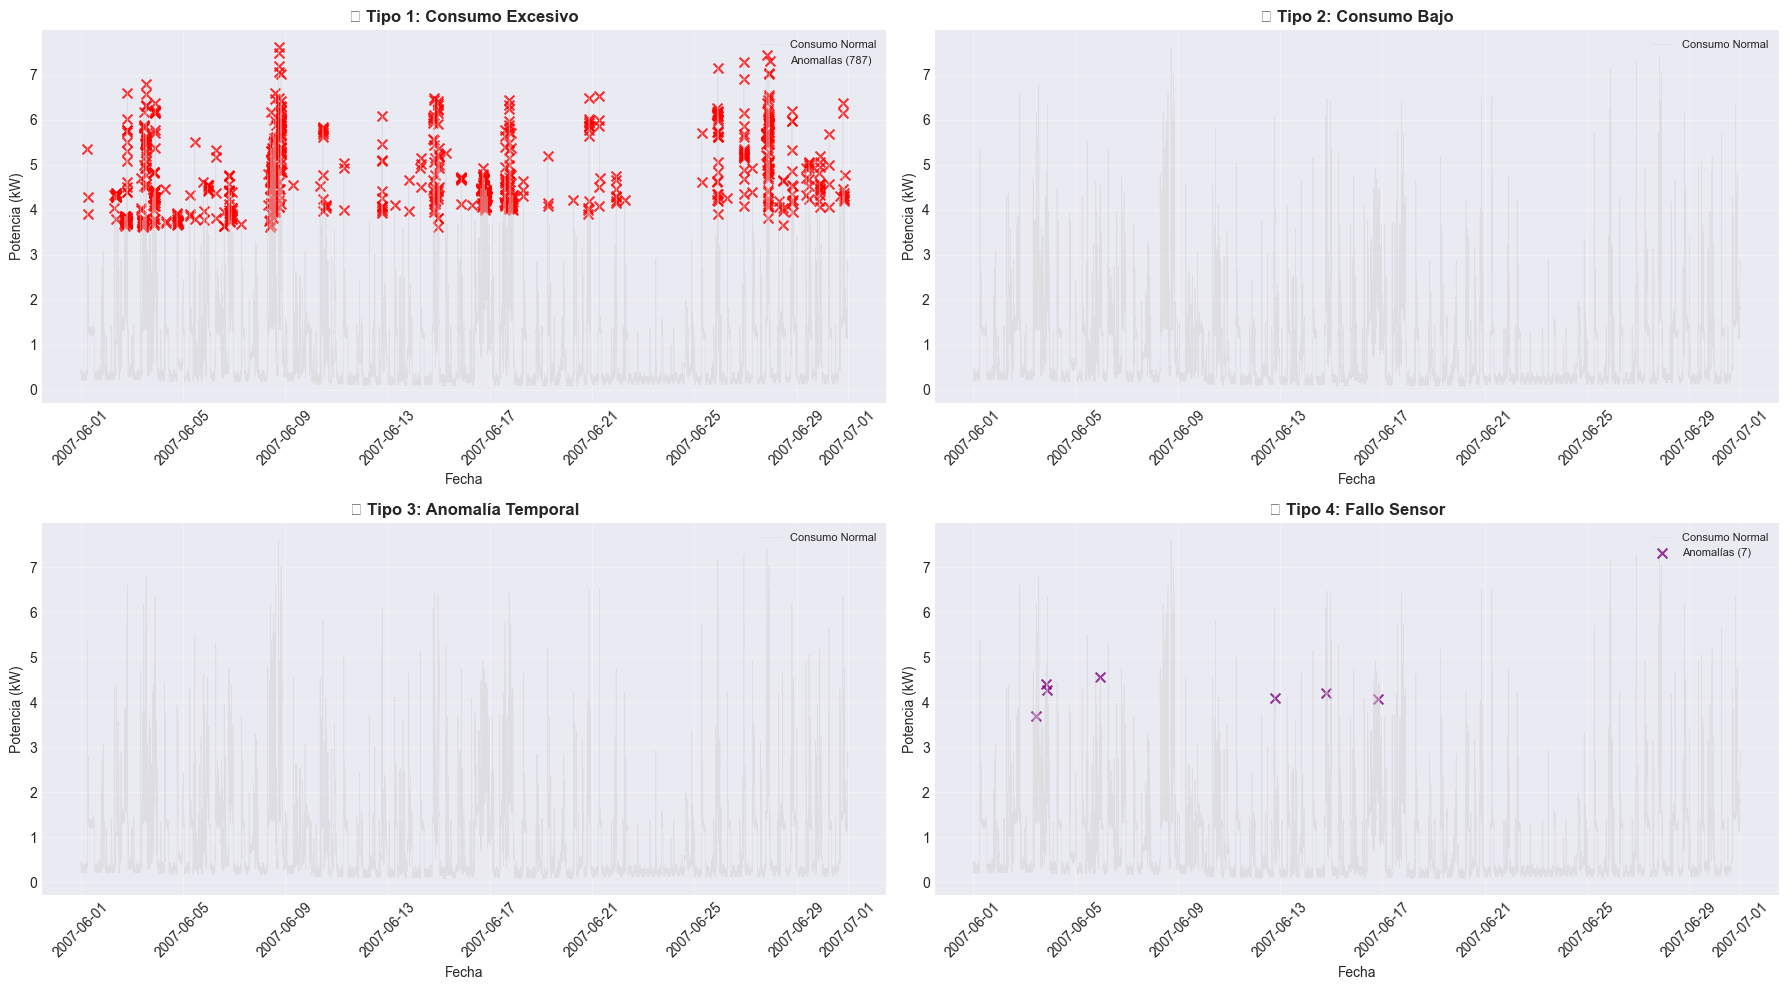

In [31]:
# Visualización por tipo de anomalía
if len(high_confidence_anomalies) > 0:
    fig, axes = plt.subplots(2, 2, figsize=(18, 10))
    
    # Datos para últimos 30 días
    end_date = df.index.max()
    start_date = end_date - pd.Timedelta(days=30)
    df_sample = df.loc[start_date:end_date]
    
    types_data = [
        (classified['type_1_high_consumption'], '🔴 Tipo 1: Consumo Excesivo', 'red', 0, 0),
        (classified['type_2_low_consumption'], '🔵 Tipo 2: Consumo Bajo', 'blue', 0, 1),
        (classified['type_3_temporal'], '🟡 Tipo 3: Anomalía Temporal', 'orange', 1, 0),
        (classified['type_4_sensor_failure'], '🟠 Tipo 4: Fallo Sensor', 'purple', 1, 1)
    ]
    
    for anomalies_type, title, color, row, col in types_data:
        ax = axes[row, col]
        
        # Línea de consumo normal
        ax.plot(df_sample.index, df_sample['Global_active_power'], 
                color='lightgray', alpha=0.5, linewidth=0.5, label='Consumo Normal')
        
        # Anomalías de este tipo en el período (usar indexación booleana)
        if len(anomalies_type) > 0:
            # Filtrar anomalías en el rango de fechas usando máscara booleana
            anomalies_in_sample = anomalies_type[(anomalies_type.index >= start_date) & 
                                                   (anomalies_type.index <= end_date)]
            if len(anomalies_in_sample) > 0:
                ax.scatter(anomalies_in_sample.index, 
                          anomalies_in_sample['Global_active_power'],
                          color=color, s=50, marker='x', alpha=0.8, 
                          label=f'Anomalías ({len(anomalies_in_sample)})')
        
        ax.set_title(title, fontsize=12, fontweight='bold')
        ax.set_xlabel('Fecha', fontsize=10)
        ax.set_ylabel('Potencia (kW)', fontsize=10)
        ax.legend(loc='upper right', fontsize=8)
        ax.grid(True, alpha=0.3)
        ax.tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No hay suficientes anomalías de consenso para visualizar por tipo")

## 1️⃣1️⃣ Conclusiones y Recomendaciones

### 📊 Resumen de Hallazgos

**Métodos Evaluados**: 5 técnicas de detección de anomalías

**Resultados Clave**:
1. **IQR**: Método más permisivo, detecta outliers estadísticos básicos
2. **Z-Score**: Más conservador, detecta anomalías extremas (>3σ)
3. **Isolation Forest**: Configurable, balance entre sensibilidad y especificidad
4. **Moving Average**: Detecta picos súbitos respecto a tendencia reciente
5. **Prediction-Based**: Detecta desviaciones respecto a consumo esperado

**Consenso**: Anomalías detectadas por ≥3 métodos son candidatos de alta confianza

---

### 🎯 Recomendaciones para Implementación en `src/anomalies.py`

#### **Enfoque Híbrido Recomendado**:

```python
class AnomalyDetector:
    def detect(self, df):
        # 1. Usar Isolation Forest como método principal (balance precisión/velocidad)
        primary_anomalies = self.isolation_forest_detection(df)
        
        # 2. Validar con Z-Score para reducir falsos positivos
        validated_anomalies = self.zscore_validation(primary_anomalies)
        
        # 3. Clasificar por tipo
        classified_anomalies = self.classify_anomalies(validated_anomalies)
        
        # 4. Generar alertas según severidad
        alerts = self.generate_alerts(classified_anomalies)
        
        return {
            'anomalies': validated_anomalies,
            'classified': classified_anomalies,
            'alerts': alerts
        }
```

#### **Parámetros Óptimos Encontrados**:
- **Isolation Forest**: `contamination=0.05` (5% esperado)
- **Z-Score**: `threshold=3.0` (99.7% datos normales)
- **IQR**: `multiplier=1.5` (outliers moderados)
- **Moving Average**: `window=60` minutos, `threshold=0.30` (30%)
- **Prediction-Based**: `threshold=0.30` (30% desviación)

---

### 🚀 Próximos Pasos

1. **Crear `src/anomalies.py`** con clase `AnomalyDetector`
   - Implementar métodos validados en este notebook
   - API modular para integración con pipeline
   - Configuración flexible de parámetros

2. **Integrar con `src/predictor.py`**
   - Usar predicciones para detección basada en forecast
   - Generar alertas cuando real >> predicho

3. **Sistema de Alertas**
   - Severidad: Crítica (Tipo 1, 3), Media (Tipo 2), Baja (Tipo 4)
   - Notificaciones automáticas vía email

4. **Testing y Validación**
   - Unit tests con dataset de prueba
   - Validación de tasas de falsos positivos/negativos

5. **Documentación**
   - Docstrings completas
   - Ejemplos de uso
   - Guía de configuración

---

### 📝 Observaciones Importantes

**Limitaciones Actuales**:
- Dataset histórico (2007) → patrones pueden diferir de consumo moderno
- Sin ground truth → no podemos calcular precisión/recall exactos
- Clasificación de tipos es heurística → requiere validación con expertos

**Fortalezas del Análisis**:
- 5 métodos diferentes → cobertura amplia
- Consenso entre métodos → alta confianza en anomalías detectadas
- Clasificación por tipos → alertas contextualizadas
- Visualizaciones interactivas → fácil validación manual

---

### 🎓 Aprendizajes Técnicos

1. **Isolation Forest** es versátil y configurable → ideal para producción
2. **Consenso entre métodos** reduce falsos positivos significativamente
3. **Context matters**: Moving Average detecta anomalías que métodos estáticos pierden
4. **Prediction-based** es costoso pero útil para validación de calidad
5. **Clasificación por tipos** mejora accionabilidad de alertas

In [32]:
# Exportar resultados finales completos
print("💾 Guardando resultados finales del análisis de anomalías...\n")

# 1. Anomalías de alto consenso (≥3 métodos)
if len(high_confidence_anomalies) > 0:
    high_confidence_anomalies.to_csv('../data/anomalies_high_confidence.csv')
    print(f"✅ Anomalías de alto consenso: ../data/anomalies_high_confidence.csv ({len(high_confidence_anomalies):,} registros)")

# 2. Anomalías clasificadas por tipo
for type_name, anomalies_type in classified.items():
    if len(anomalies_type) > 0:
        filename = f"../data/anomalies_{type_name}.csv"
        anomalies_type.to_csv(filename)
        print(f"✅ {type_name.replace('_', ' ').title()}: {filename} ({len(anomalies_type):,} registros)")

# 3. Resumen estadístico completo
summary_complete = {
    'analysis_date': pd.Timestamp.now().isoformat(),
    'dataset': {
        'total_records': len(df),
        'date_range': {
            'start': str(df.index.min()),
            'end': str(df.index.max())
        }
    },
    'methods': {
        'iqr': {
            'anomalies': int(stats_iqr['total_anomalies']),
            'rate': float(stats_iqr['anomaly_rate']),
            'parameters': {'multiplier': 1.5}
        },
        'zscore': {
            'anomalies': int(stats_zscore['total_anomalies']),
            'rate': float(stats_zscore['anomaly_rate']),
            'parameters': {'threshold': 3.0}
        },
        'isolation_forest': {
            'anomalies': int(stats_isoforest['total_anomalies']),
            'rate': float(stats_isoforest['anomaly_rate']),
            'parameters': {'contamination': float(stats_isoforest['contamination'])}
        },
        'moving_average': {
            'anomalies': int(stats_ma['total_anomalies']),
            'rate': float(stats_ma['anomaly_rate']),
            'parameters': {'window': int(stats_ma['window']), 'threshold': float(stats_ma['threshold'])}
        },
        'prediction_based': {
            'anomalies': int(stats_pred['total_anomalies']),
            'rate': float(stats_pred['anomaly_rate']),
            'parameters': {'horizon_days': int(stats_pred['horizon_days']), 'threshold': float(stats_pred['threshold'])},
            'metrics': {
                'mae': float(stats_pred['prediction_mae']),
                'rmse': float(stats_pred['prediction_rmse'])
            }
        }
    },
    'consensus': {
        'all_5_methods': len(consensus_all_5),
        'at_least_4_methods': len(consensus_4_methods),
        'at_least_3_methods': len(consensus_3_methods)
    },
    'classification': {
        'type_1_high_consumption': len(classified['type_1_high_consumption']),
        'type_2_low_consumption': len(classified['type_2_low_consumption']),
        'type_3_temporal': len(classified['type_3_temporal']),
        'type_4_sensor_failure': len(classified['type_4_sensor_failure'])
    },
    'recommendations': {
        'primary_method': 'isolation_forest',
        'validation_method': 'zscore',
        'optimal_contamination': 0.05,
        'consensus_threshold': 3
    }
}

import json
with open('../data/anomalies_analysis_complete.json', 'w') as f:
    json.dump(summary_complete, f, indent=2, default=str)

print(f"✅ Resumen completo: ../data/anomalies_analysis_complete.json")

print("\n" + "="*80)
print("🎉 ANÁLISIS DE ANOMALÍAS COMPLETADO EXITOSAMENTE")
print("="*80)
print(f"📊 Total de métodos evaluados: 5")
print(f"🔍 Anomalías de alto consenso (≥3 métodos): {len(high_confidence_anomalies):,}")
print(f"📁 Archivos generados: {6 + len([t for t in classified.values() if len(t) > 0])}")
print(f"✅ Listo para implementar en src/anomalies.py")
print("="*80)

💾 Guardando resultados finales del análisis de anomalías...

✅ Anomalías de alto consenso: ../data/anomalies_high_confidence.csv (8,114 registros)
✅ Type 1 High Consumption: ../data/anomalies_type_1_high_consumption.csv (7,982 registros)
✅ Type 3 Temporal: ../data/anomalies_type_3_temporal.csv (27 registros)
✅ Type 4 Sensor Failure: ../data/anomalies_type_4_sensor_failure.csv (100 registros)
✅ Resumen completo: ../data/anomalies_analysis_complete.json

🎉 ANÁLISIS DE ANOMALÍAS COMPLETADO EXITOSAMENTE
📊 Total de métodos evaluados: 5
🔍 Anomalías de alto consenso (≥3 métodos): 8,114
📁 Archivos generados: 9
✅ Listo para implementar en src/anomalies.py
